# Using RNN/LSTM to predict Stock Prices

Long Short Term Memory(LSTM) Networks are a special type of Recurrent Neural Networks(RNN) which improves the learning of data based on the concept of short term memory. Based on the last 'n' values, predict the next value. 

In [4]:
import pandas as pd
import numpy as np

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

### Install the nsepy library to get stock prices

In [2]:
pip install nselib

Note: you may need to restart the kernel to use updated packages.


In [51]:
# Getting Stock data using nselib library
from nselib import capital_market

# Fetching the data
StockData = capital_market.price_volume_and_deliverable_position_data(symbol='SBIN', from_date='23-10-2022', to_date='23-10-2023')

print(StockData.shape)
StockData.tail()

(251, 15)


,Symbol,Series,Date,PrevClose,OpenPrice,HighPrice,LowPrice,LastPrice,ClosePrice,AveragePrice,TotalTradedQuantity,TurnoverInRs,No.ofTrades,DeliverableQty,%DlyQttoTradedQty
246,SBIN,EQ,17-Oct-2023,575.65,577.70,579.95,575.30,576.70,576.45,577.46,"1,07,65,224","6,21,64,66,935.70","2,69,728","58,59,053",54.43
247,SBIN,EQ,18-Oct-2023,576.45,577.75,579.25,569.35,572.75,572.65,573.26,"1,17,77,454","6,75,15,31,244.10","2,70,057","56,08,793",47.62
248,SBIN,EQ,19-Oct-2023,572.65,569.80,574.00,567.00,571.30,571.20,570.92,"1,14,41,499","6,53,21,50,778.60","2,39,777","50,51,411",44.15
249,SBIN,EQ,20-Oct-2023,571.20,569.90,570.00,562.10,562.80,563.10,565.15,"1,11,10,988","6,27,93,75,187.50","2,82,726","55,78,493",50.21
250,SBIN,EQ,23-Oct-2023,563.10,563.10,566.00,551.00,552.40,552.95,559.35,"1,18,75,035","6,64,23,19,960.75","2,63,251","49,62,537",41.79


### Plotting the closing  prices of stock

<Axes: xlabel='Date'>

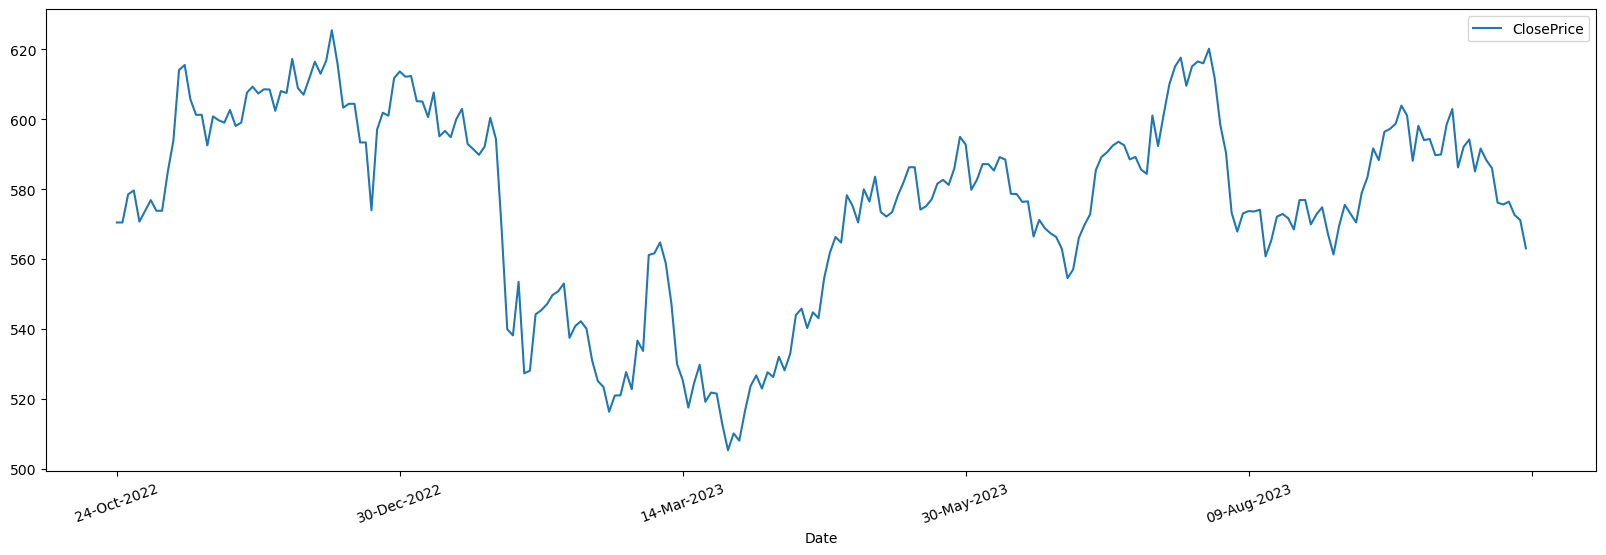

In [6]:
%matplotlib inline
StockData.plot(x='Date', y='ClosePrice', kind='line', figsize=(20,6), rot=20)

### Preparing the data

In [7]:
FullData=StockData[['ClosePrice']].values
FullData[-20:]

array([[598.15],
       [594.05],
       [594.4 ],
       [589.75],
       [589.95],
       [598.55],
       [602.95],
       [586.25],
       [592.15],
       [594.25],
       [585.1 ],
       [591.65],
       [588.35],
       [586.05],
       [576.15],
       [575.65],
       [576.45],
       [572.65],
       [571.2 ],
       [563.1 ]])

### Feature Scaling for fast training

In [8]:
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

X[0:5]

array([[0.54223887],
       [0.54223887],
       [0.60923845],
       [0.61839367],
       [0.5443196 ]])

In [10]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10             # next day's Price Prediction is based on last how many past day's prices

# Iterate through the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [25]:
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
X_data.shape

(240, 10, 1)

In [13]:
X_data[0:2]

array([[[0.54223887],
        [0.54223887],
        [0.60923845],
        [0.61839367],
        [0.5443196 ],
        [0.56970454],
        [0.59550562],
        [0.57012068],
        [0.57012068],
        [0.66208906]],

       [[0.54223887],
        [0.60923845],
        [0.61839367],
        [0.5443196 ],
        [0.56970454],
        [0.59550562],
        [0.57012068],
        [0.57012068],
        [0.66208906],
        [0.73741157]]])

In [31]:
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
y_data.shape

(240, 1)

In [32]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [33]:
# Printing the shape of training and testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(235, 10, 1)
(235, 1)
(5, 10, 1)
(5, 1)


In [17]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:5], y_train[0:5]):
    print(inp,'-->', out)

[[0.54223887]
 [0.54223887]
 [0.60923845]
 [0.61839367]
 [0.5443196 ]
 [0.56970454]
 [0.59550562]
 [0.57012068]
 [0.57012068]
 [0.66208906]] --> [0.73741157]
[[0.54223887]
 [0.60923845]
 [0.61839367]
 [0.5443196 ]
 [0.56970454]
 [0.59550562]
 [0.57012068]
 [0.57012068]
 [0.66208906]
 [0.73741157]] --> [0.90553475]
[[0.60923845]
 [0.61839367]
 [0.5443196 ]
 [0.56970454]
 [0.59550562]
 [0.57012068]
 [0.57012068]
 [0.66208906]
 [0.73741157]
 [0.90553475]] --> [0.91718685]
[[0.61839367]
 [0.5443196 ]
 [0.56970454]
 [0.59550562]
 [0.57012068]
 [0.57012068]
 [0.66208906]
 [0.73741157]
 [0.90553475]
 [0.91718685]] --> [0.83562214]
[[0.5443196 ]
 [0.56970454]
 [0.59550562]
 [0.57012068]
 [0.57012068]
 [0.66208906]
 [0.73741157]
 [0.90553475]
 [0.91718685]
 [0.83562214]] --> [0.7985851]


In [18]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


### Fitting the Deep Learning LSTM model

In [19]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [20]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
47/47 [==============================] - 2s 4ms/step - loss: 0.3601
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1820
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0306
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0240
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0237
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0237
Epoch 8/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 9/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 10/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 11/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 12/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 13/100
47/47 [=================

### Generating predictions on testing data

In [34]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

1/1 [==============================] - 0s 44ms/step


array([[581.39154],
       [577.32385],
       [576.92535],
       [576.4062 ],
       [574.6515 ]], dtype=float32)

In [35]:
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
orig

array([[575.65],
       [576.45],
       [572.65],
       [571.2 ],
       [563.1 ]])

### Measuring the Accuracy of predictions

In [36]:
# Accuracy of the predictions
100 - (100*(abs(orig-predicted_Price)/orig)).mean()

99.0283115902039

### Plotting the predictions for Testing data

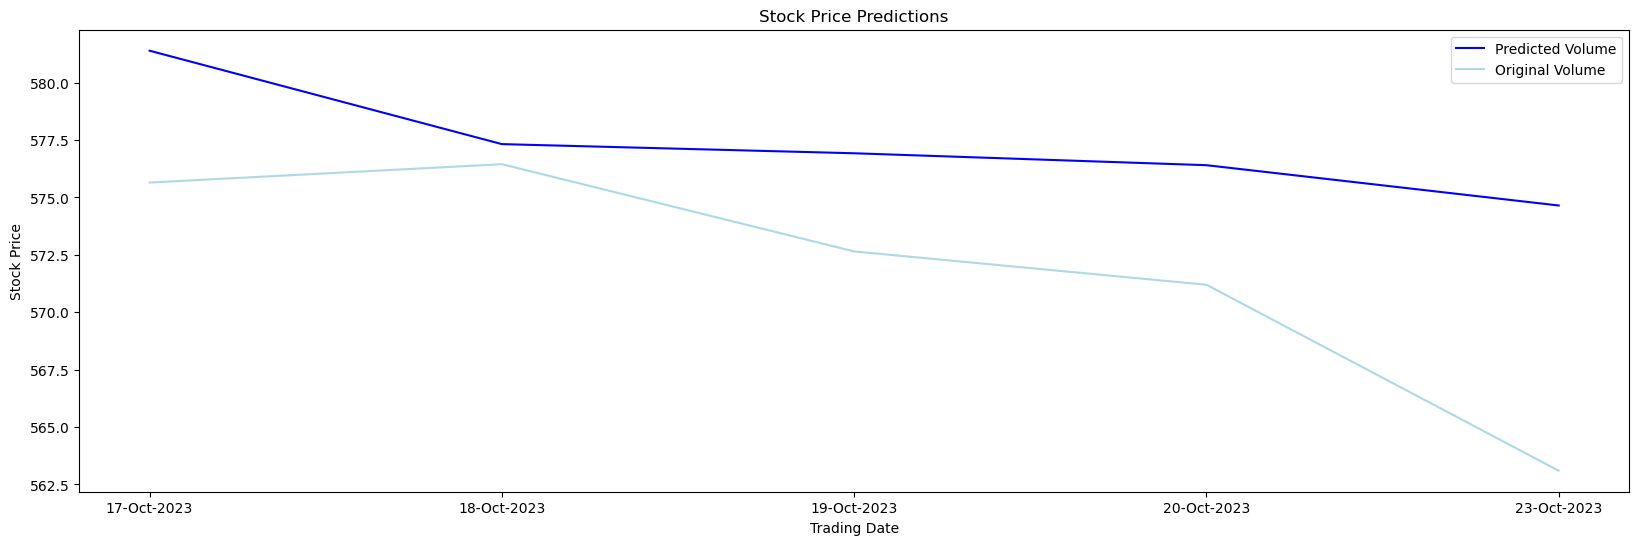

In [37]:
# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

### Plotting the predictions for full data

1/1 [==============================] - 0s 64ms/step


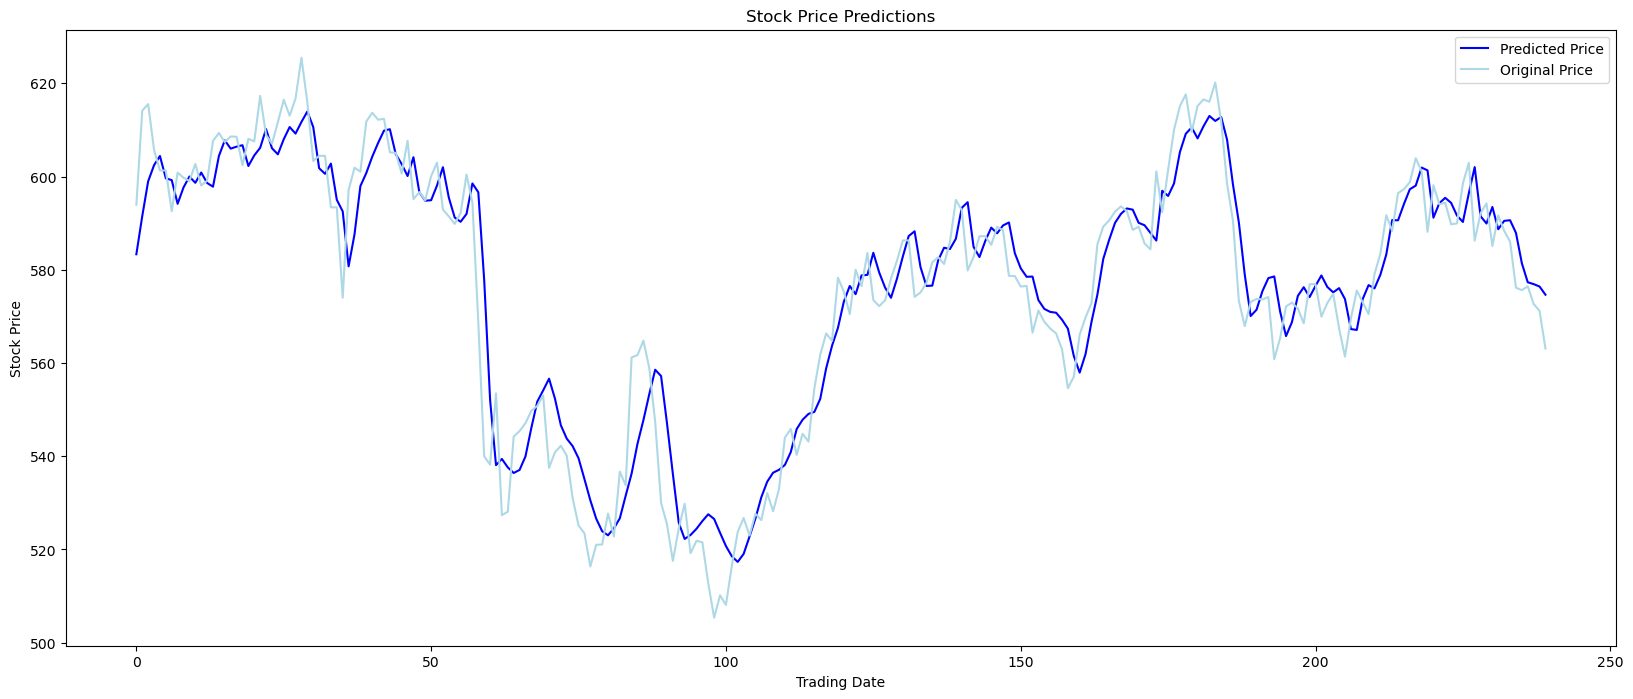

In [38]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## Multi step prediction

What if you need to predict the prices for multiple days in future instead of just one day? You can modify this code slightly and produce predictions for next few days. 

Its like predict the prices of the stock for the next 5 days based on last 10 days. Or like predict the prices of the stock for the next 10 days based on last 20 days, so on and so forth!

However, keep in mind, the more further you predict, the lesser accurate you might be, because stock prices are volatile and no on can know what is going to happen after 10 days! What kind of news will come? which might affect the prices of this stock!

Hence, it is recommended to predict for as less time steps as possible, for example next 2 days or next 5 days at max.

In [39]:
# Considering the Full Data again
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])

print('###################')

# Printing last 10 values of the scaled data
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[585.1 ]
 [591.65]
 [588.35]
 [586.05]
 [576.15]
 [575.65]
 [576.45]
 [572.65]
 [571.2 ]
 [563.1 ]]
###################
Scaled Prices
[0.66375364 0.71826883 0.69080316 0.67166042 0.58926342 0.58510196
 0.5917603  0.56013317 0.54806492 0.48064919]


In [40]:
# Multi step data preparation

# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(235, 10, 1)
### Output Data Shape ###
(235, 5)


In [41]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [42]:
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)

print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(230, 10, 1)
(230, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


In [43]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.54223887]
 [0.54223887]
 [0.60923845]
 [0.61839367]
 [0.5443196 ]
 [0.56970454]
 [0.59550562]
 [0.57012068]
 [0.57012068]
 [0.66208906]]
====>
[0.73741157 0.90553475 0.91718685 0.83562214 0.7985851 ]
####################
[[0.54223887]
 [0.60923845]
 [0.61839367]
 [0.5443196 ]
 [0.56970454]
 [0.59550562]
 [0.57012068]
 [0.57012068]
 [0.66208906]
 [0.73741157]]
====>
[0.90553475 0.91718685 0.83562214 0.7985851  0.7985851 ]
####################


In [44]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


# Fitting the deep learning model

In [45]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [46]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
46/46 [==============================] - 6s 12ms/step - loss: 0.3573
Epoch 2/100
46/46 [==============================] - 1s 12ms/step - loss: 0.2635
Epoch 3/100
46/46 [==============================] - 2s 38ms/step - loss: 0.1980
Epoch 4/100
46/46 [==============================] - 1s 12ms/step - loss: 0.1494
Epoch 5/100
46/46 [==============================] - 1s 13ms/step - loss: 0.1141
Epoch 6/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0883
Epoch 7/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0700
Epoch 8/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0549
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0450
Epoch 10/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0362
Epoch 11/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0310
Epoch 12/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0268
Epoch 13/100
46/46 [=====

# Generating predictions on testing data

In [47]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

1/1 [==============================] - 1s 744ms/step
#### Predicted Prices ####
[[596.7829  597.24475 597.40216 595.04987 595.4719 ]
 [588.6638  588.674   589.2278  587.6451  587.68616]
 [591.43646 591.8269  592.4476  590.2996  590.6062 ]
 [592.5413  593.0769  593.6106  591.2357  591.7175 ]
 [588.40826 588.84045 589.839   587.69653 587.96136]]

#### Original Prices ####
[[585.1  591.65 588.35 586.05 576.15]
 [591.65 588.35 586.05 576.15 575.65]
 [588.35 586.05 576.15 575.65 576.45]
 [586.05 576.15 575.65 576.45 572.65]
 [576.15 575.65 576.45 572.65 571.2 ]]


Each row represents the original prices and the predicted prices.

We will compare them one row at a time.

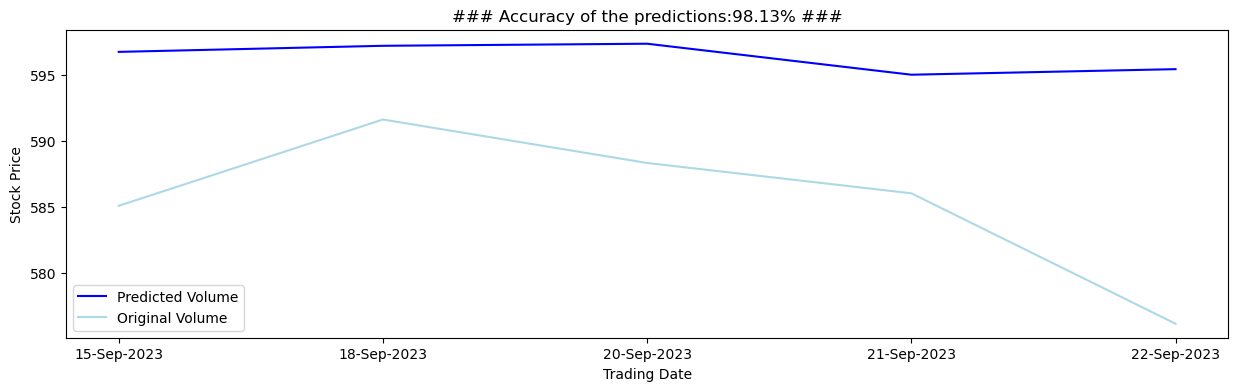

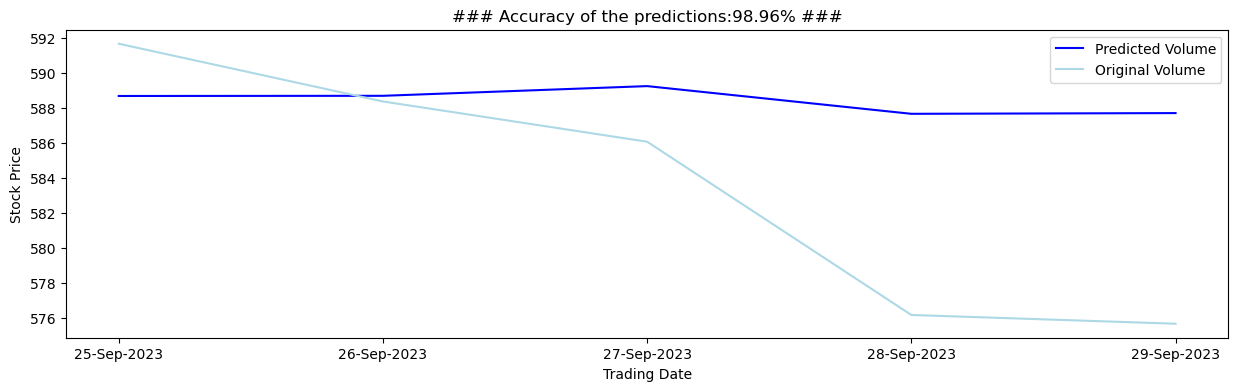

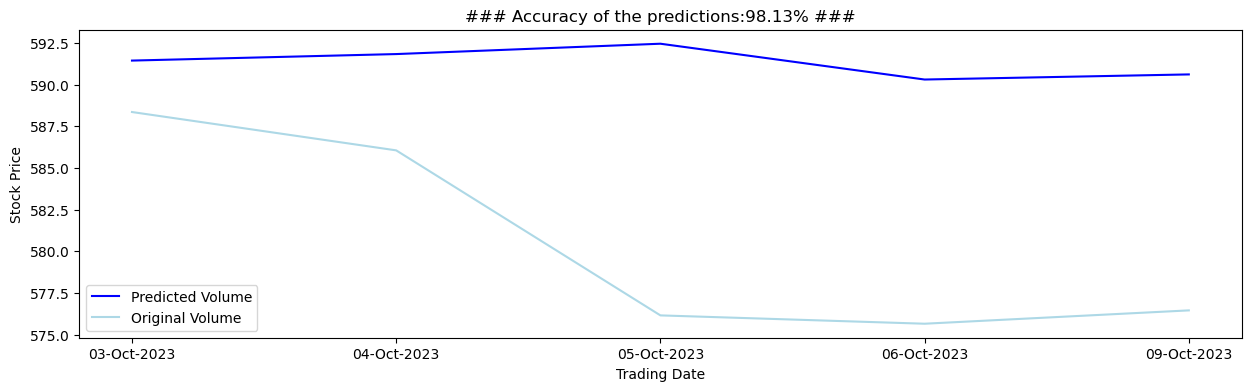

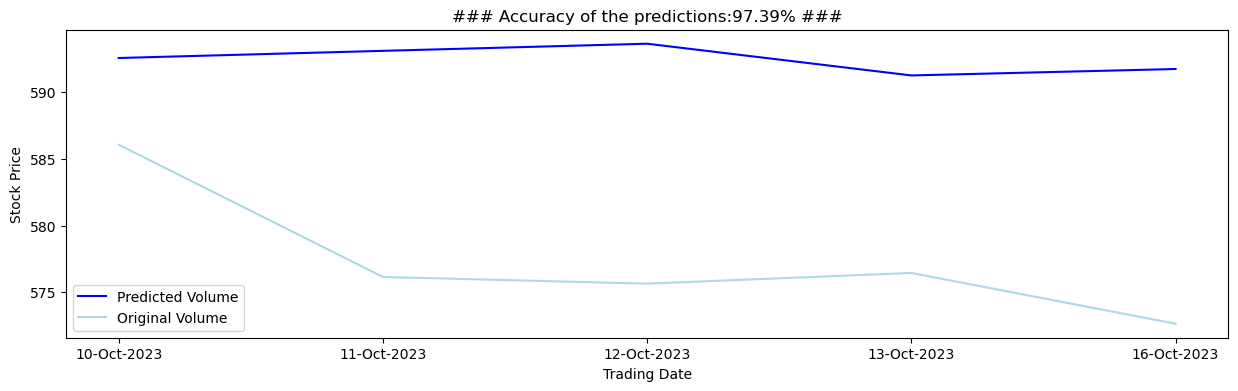

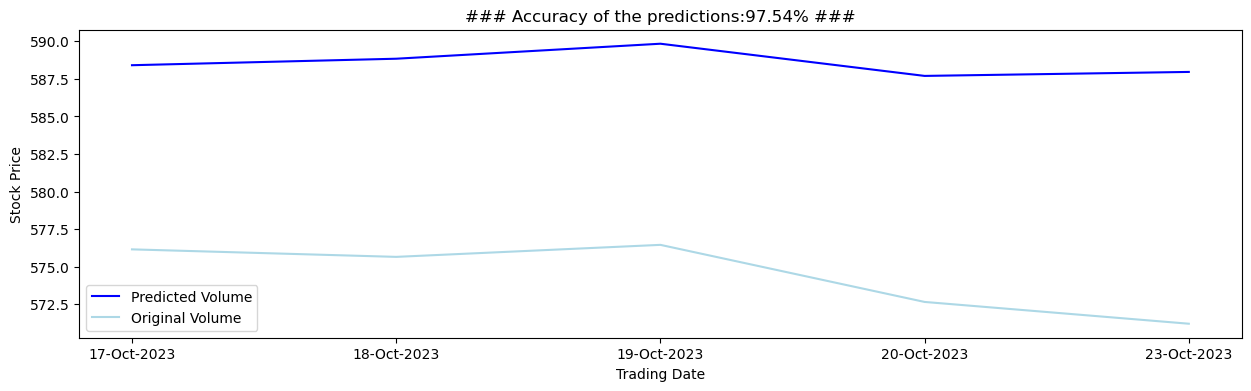

In [48]:
import matplotlib.pyplot as plt

for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')

    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]

    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Date'])
    plt.ylabel('Stock Price')

    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(15)
    fig.set_figheight(4)
    plt.show()

## Making predictions for the next 5 days

In [49]:
# Making predictions on test data
Last10DaysPrices=np.array([588.15,
       598.15,
       594.05,
       594.4 ,
       589.75,
       589.95,
       598.55,
       602.95,
       586.25,
       592.15])

# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)

NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)

# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)

# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

1/1 [==============================] - 0s 50ms/step


array([[590.47845, 590.32635, 590.702  , 589.31757, 589.18427]],
      dtype=float32)

In [50]:
FullData=StockData[['ClosePrice']].values
FullData[-10:]

array([[591.65],
       [588.35],
       [586.05],
       [576.15],
       [575.65],
       [576.45],
       [572.65],
       [571.2 ],
       [563.1 ],
       [552.95]])